Add the driver folder to system PATH or PYTHONPATH

In [1]:
import sys
sys.path.append("driver")

In [11]:
import os
import glob
import cv2
import numpy as np
import time
import torch
import torch.nn as nn

from matplotlib import pyplot as plt

from driver.driver import io_shape_dict
from driver.driver_base import FINNExampleOverlay
from utils import (clip_coords, scale_coords, letterbox, 
                   xywh2xyxy, non_max_suppression,  
                   visualize_boxes)
from models import Detect

In [12]:
driver = FINNExampleOverlay(
    bitfile_name="./bitfile/finn-accel.bit",
    platform="zynq-iodma",
    io_shape_dict=io_shape_dict,
    batch_size=1,
    runtime_weight_dir="runtime_weights/",
)

# Throughput Test

In [13]:
driver.throughput_test()

{'runtime[ms]': 61.58280372619629,
 'throughput[images/s]': 16.238299322098204,
 'DRAM_in_bandwidth[MB/s]': 8.43040538245508,
 'DRAM_out_bandwidth[MB/s]': 0.04939690653782274,
 'fclk[mhz]': 99.999,
 'batch_size': 1,
 'fold_input[ms]': 0.07271766662597656,
 'pack_input[ms]': 0.051021575927734375,
 'copy_input_data_to_device[ms]': 0.7297992706298828,
 'copy_output_data_from_device[ms]': 0.09608268737792969,
 'unpack_output[ms]': 0.44417381286621094,
 'unfold_output[ms]': 0.057697296142578125}

# Inference

In [14]:
test_img_folder = "./images/"
test_img_paths = glob.glob(test_img_folder + "*.jpg")
output_path = "./test_outputs/"
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [16]:
names = ['face']
nc  = 1
anchors = np.array([[10,14,23,27,37,58]]) / np.array([32])
scale = np.load("./bitfile/scale.npy")
detect_head = Detect(nc, anchors)

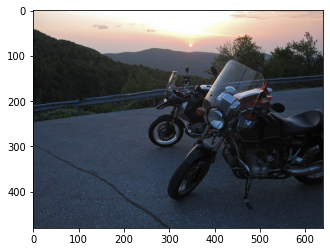

Preprocessing time: 40.81 ms
Model execution time: 61.89 ms
Postprocessing time: 1.89 ms
1 face


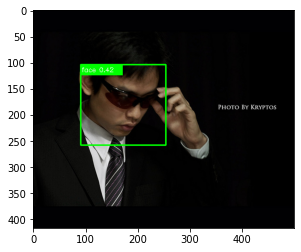

Preprocessing time: 30.36 ms
Model execution time: 61.76 ms
Postprocessing time: 6.08 ms


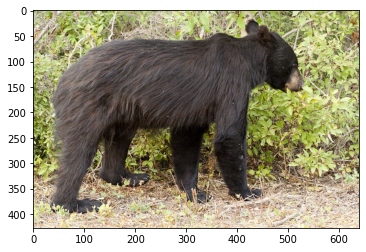

Preprocessing time: 43.78 ms
Model execution time: 61.78 ms
Postprocessing time: 3.49 ms


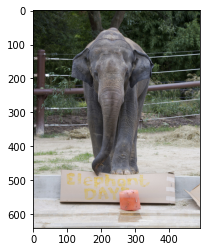

Preprocessing time: 47.50 ms
Model execution time: 61.78 ms
Postprocessing time: 1.93 ms


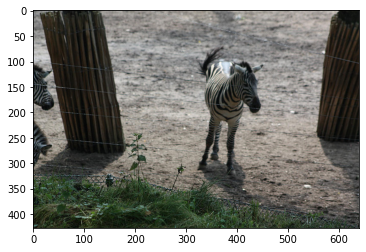

Preprocessing time: 37.23 ms
Model execution time: 61.78 ms
Postprocessing time: 1.90 ms


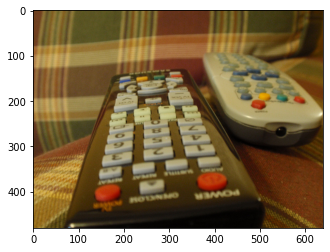

Preprocessing time: 44.05 ms
Model execution time: 61.76 ms
Postprocessing time: 1.93 ms


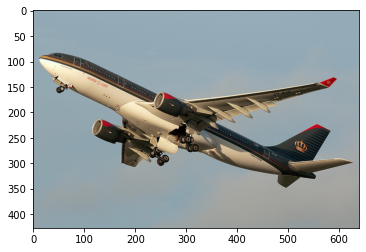

Preprocessing time: 37.53 ms
Model execution time: 61.74 ms
Postprocessing time: 1.90 ms


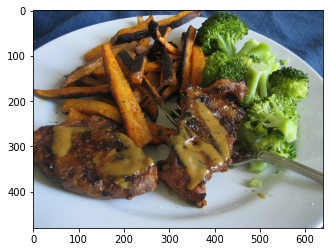

Preprocessing time: 39.60 ms
Model execution time: 61.75 ms
Postprocessing time: 3.40 ms


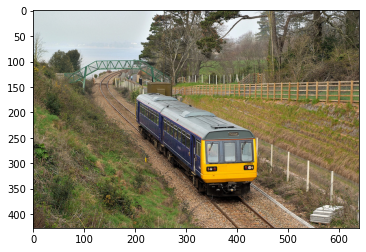

Preprocessing time: 41.80 ms
Model execution time: 61.77 ms
Postprocessing time: 3.44 ms


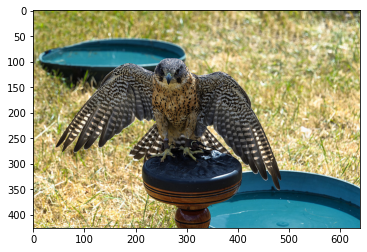

Preprocessing time: 41.21 ms
Model execution time: 61.67 ms
Postprocessing time: 1.92 ms
3 face


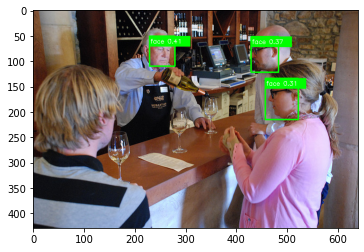

Preprocessing time: 36.03 ms
Model execution time: 61.82 ms
Postprocessing time: 6.27 ms


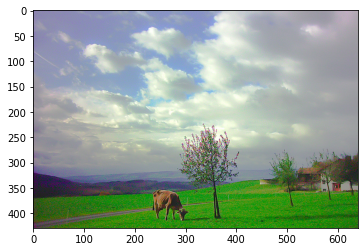

Preprocessing time: 41.70 ms
Model execution time: 61.82 ms
Postprocessing time: 1.95 ms


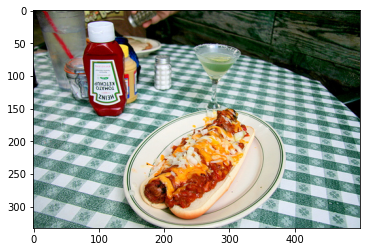

Preprocessing time: 29.94 ms
Model execution time: 61.73 ms
Postprocessing time: 1.92 ms
1 face


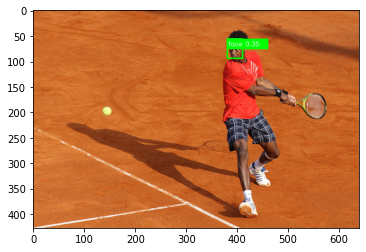

Preprocessing time: 39.37 ms
Model execution time: 61.89 ms
Postprocessing time: 6.00 ms


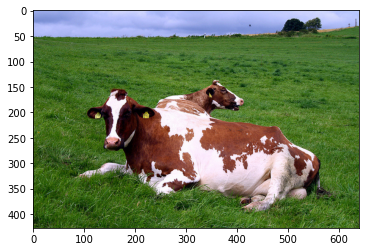

Preprocessing time: 43.51 ms
Model execution time: 61.74 ms
Postprocessing time: 1.94 ms
2 face


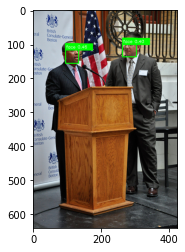

Preprocessing time: 39.41 ms
Model execution time: 61.78 ms
Postprocessing time: 6.18 ms


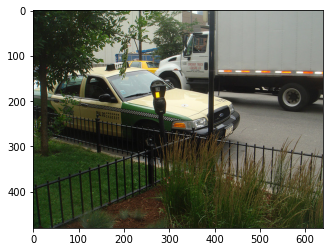

Preprocessing time: 40.12 ms
Model execution time: 61.84 ms
Postprocessing time: 1.95 ms
1 face


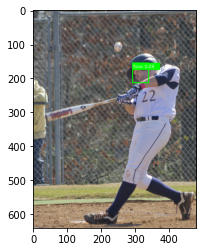

Preprocessing time: 42.97 ms
Model execution time: 61.76 ms
Postprocessing time: 6.00 ms
2 face


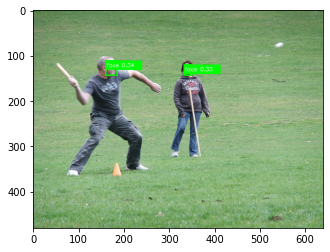

Preprocessing time: 42.68 ms
Model execution time: 61.84 ms
Postprocessing time: 6.17 ms


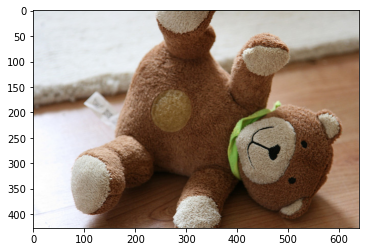

Preprocessing time: 34.00 ms
Model execution time: 61.72 ms
Postprocessing time: 1.93 ms
Overall FPS: 9.54
Average preprocessing time: 39.68 ms
Average postprocessing time: 3.41 ms


In [21]:
total_time = 0
total_preprocessing_time = 0
total_postprocessing_time = 0
for number, test_img_path in enumerate(test_img_paths):
    start_time = time.time() # Start time for the entire operation
    img_org = cv2.imread(test_img_path)
    img = img_org.copy()
    
    h, w, _ = img_org.shape
    img, ratio, (dw, dh) = letterbox(img, (416,416), auto=False)
    
    img = img[:, :, ::-1]
    img = img.astype(np.uint8)
    driver_in = np.expand_dims(img, 0)
    preprocessing_time = time.time() - start_time  # End time for preprocessing
    total_preprocessing_time += preprocessing_time

    start_time = time.time() # Start time for model execution
    output = driver.execute(driver_in)
    model_time = time.time() - start_time
    
    start_time = time.time()  # Start time for postprocessing
    output = scale*output
    output = output.transpose(0,3,1,2)

    output = torch.from_numpy(output)
    pred = detect_head([output])[0]

    pred = non_max_suppression(pred, conf_thres=0.20, iou_thres=0.10, classes=None, max_det=1000)
    
    boxes_detected, class_names_detected, probs_detected = [], [], []
    # Process predictions
    for i, det in enumerate(pred):  # per image
        if len(det):
            # Rescale boxes from img_size to im0 size
            det[:, :4] = scale_coords(img.shape, det[:, :4], img_org.shape).round()
            # Print results
            for c in np.unique(det[:, -1]):
                n = (det[:, -1] == c).sum()  # detections per class
                print(f"{n} {names[int(c)]}")  # add to string
            # Write results
            for *xyxy, conf, cls in reversed(det):
                c = int(cls)  # integer class
                label = f'{names[c]} {conf:.2f}'
                boxes_detected.append(xyxy)
                class_names_detected.append(names[c])
                probs_detected.append(conf)
    
    postprocessing_time = time.time() - start_time
    total_postprocessing_time += postprocessing_time

    # Visualize.
    image_boxes = visualize_boxes(img_org, boxes_detected, class_names_detected, probs_detected)
    cv2.imwrite(output_path+f"{number}.jpg", image_boxes)
    
    plt.imshow(cv2.cvtColor(image_boxes, cv2.COLOR_BGR2RGB))
    plt.show()
    
    total_time += (preprocessing_time + model_time + postprocessing_time)
    print(f"Preprocessing time: {preprocessing_time*1000:.2f} ms")
    print(f"Model execution time: {model_time*1000:.2f} ms")
    print(f"Postprocessing time: {postprocessing_time*1000:.2f} ms")
    
total_fps = len(test_img_paths) / total_time
avg_preprocessing_time = total_preprocessing_time / len(test_img_paths)
avg_postprocessing_time = total_postprocessing_time / len(test_img_paths)

print(f"Overall FPS: {total_fps:.2f}")
print(f"Average preprocessing time: {avg_preprocessing_time*1000:.2f} ms")
print(f"Average postprocessing time: {avg_postprocessing_time*1000:.2f} ms")
